In [1]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

Matplotlib is building the font cache; this may take a moment.


In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)

data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

In [4]:
print(x_train.shape)
print(x_train.device)

torch.Size([40000, 3, 32, 32])
mps:0


In [5]:
class ConvNet(nn.Module):
    def __init__(self, 
                 num_channels: int, 
                 num_classes: int, 
                 filters: list[int], 
                 activation: nn.Module = nn.ReLU
                 ):
        super().__init__()
        conv_layers = [
            nn.Conv2d(num_channels, filters[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filters[0]),
            activation()
        ]
        for i in range(len(filters)-1):
            conv_layers += [
                nn.Conv2d(filters[i], filters[i+1], kernel_size=3, stride=2, padding=1), 
                nn.BatchNorm2d(filters[i+1]),
                activation()
            ]
        
        conv_layers.append(nn.Conv2d(filters[-1], num_classes, kernel_size=3, stride=1, padding=1))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        h = self.conv_layers(x)
        return self.flatten(h)


In [6]:
model = ConvNet(3, 10, [64, 128, 256, 512, 1024], nn.LeakyReLU).to(device)


In [7]:
model

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affin

In [8]:
def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

def validate_model(model, valid_loader, loss_fn, all_valid_loss):
    model.eval()
    valid_loss = []
    valid_acc = []
    
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            valid_loss.append(loss.item())
            valid_acc.append(accuracy(y_pred, y))
    
    all_valid_loss.append(sum(valid_loss) / len(valid_loss))
    
    return sum(valid_acc) / len(valid_acc)

def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model: nn.Module,
                optim: torch.optim.Optimizer,
                loss_fn,
                train_loader,
                valid_loader,
                scheduler,
                epochs=10,
                batch_size=32,
                valid_every=1
                ):
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for batch in train_loader:
            x, y = batch
            optim.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        scheduler.step()
        
        if epoch % valid_every == 0:
            valid_acc = validate_model(model, valid_loader, loss_fn, all_valid_loss)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {all_valid_loss[-1]}, "
                f"Acc: {valid_acc}"
            )
    
    plot_loss(all_train_loss, all_valid_loss)


In [9]:
from torch.utils.data import Dataset, DataLoader

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

Epoch 0, Train Loss: 1.5250147620677947, Valid Loss: 1.3125521310221273, Acc: 0.5337460041046143
Epoch 1, Train Loss: 1.1021607160568236, Valid Loss: 1.4254104496952824, Acc: 0.5283546447753906
Epoch 2, Train Loss: 0.9046193225383758, Valid Loss: 0.8853409865412849, Acc: 0.6910942196846008
Epoch 3, Train Loss: 0.7323171019792557, Valid Loss: 0.8463976407965151, Acc: 0.7093650102615356
Epoch 4, Train Loss: 0.5647834594845772, Valid Loss: 0.8291368638745512, Acc: 0.7167531847953796
Epoch 5, Train Loss: 0.3936050029695034, Valid Loss: 0.8572464984255477, Acc: 0.7282348275184631
Epoch 6, Train Loss: 0.2209732099160552, Valid Loss: 0.9310198440528906, Acc: 0.7470048069953918
Epoch 7, Train Loss: 0.10396993888393044, Valid Loss: 1.0724528757527994, Acc: 0.750898540019989
Epoch 8, Train Loss: 0.04601273323837668, Valid Loss: 1.101934998989486, Acc: 0.7539936304092407
Epoch 9, Train Loss: 0.024836905907001345, Valid Loss: 1.1190882440858756, Acc: 0.7614816427230835


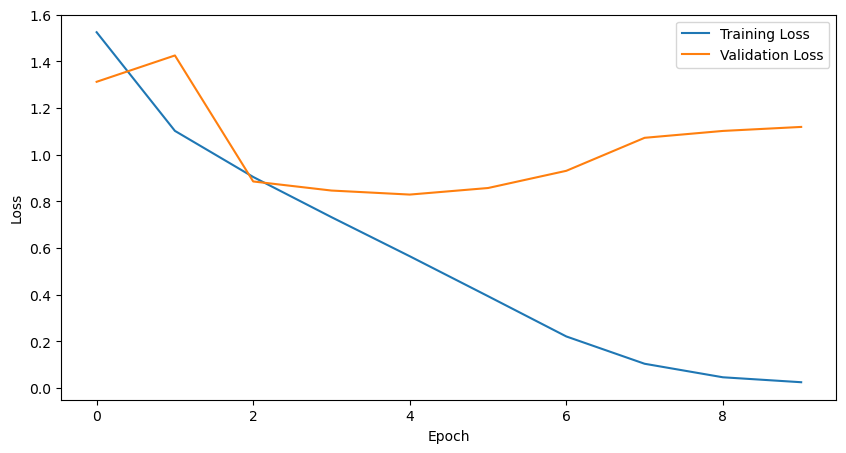

In [10]:
optim = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10)
loss_fn = nn.CrossEntropyLoss()


train_model(model, optim, loss_fn, train_dl, valid_dl, scheduler=scheduler, epochs=10, valid_every=1)

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 activation: nn.Module = nn.ReLU, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1
                 ):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), 
            nn.BatchNorm2d(out_channels),
            activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv(x)

class ResBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 activation: nn.Module = nn.ReLU, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1
                 ):
        super().__init__()
        self.conv1 = ConvBlock(
            in_channels, 
            out_channels, 
            activation, 
            kernel_size, 
            stride, 
            padding
        )

        self.idconv = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.avgpool = nn.Identity() if stride == 1 else nn.AvgPool2d(kernel_size=2, stride=stride)

        self.activation = activation()

    def forward(self, x):
        h = self.conv1(x)
        h_id = self.avgpool(self.idconv(x))
        return self.activation(h + h_id)


In [12]:
res_block = ResBlock(3, 64).to(device)
print(x_train[0].shape)
res_block(x_train[0].unsqueeze(0)).shape

for i in range(10):
    print(res_block(x_train[i].unsqueeze(0)).shape)


torch.Size([3, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])


In [13]:
class ResNet(nn.Module):
    def __init__(self,
                 num_channels: int,
                 num_classes: int,
                 filters: list[int],
                 activation: nn.Module = nn.ReLU,
                 stride: int = 2
                 ):
        super().__init__()
        res_layers = [
            ResBlock(num_channels, filters[0], activation, stride=1)
        ]
        for i in range(len(filters)-1):
            res_layers += [
                ResBlock(filters[i], filters[i+1], activation, stride=stride)
            ]
        self.res_layers = nn.Sequential(*res_layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(filters[-1], num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
            activation()
        )

    def forward(self, x):
        for _, layer in enumerate(self.res_layers):
            x = layer(x)

        h = self.avgpool(x)
        h = self.flatten(h)
        return self.linear(h)

In [17]:
model2 = ResNet(3, 10, [64, 128, 256, 512, 1024], nn.ReLU, stride=2).to(device)
model2

ResNet(
  (res_layers): Sequential(
    (0): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idconv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (avgpool): Identity()
      (activation): ReLU()
    )
    (1): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Bat

In [18]:
print(model.parameters())
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
print(model2.parameters())
total_params = sum(p.numel() for p in model2.parameters())
print(f"Number of parameters: {total_params}")



<generator object Module.parameters at 0x15f519690>
Number of parameters: 6366730
<generator object Module.parameters at 0x15f519690>
Number of parameters: 19559892


Epoch 0, Train Loss: 1.4691576690673829, Valid Loss: 1.1504261484161353, Acc: 0.655351459980011
Epoch 1, Train Loss: 1.2177997741937638, Valid Loss: 0.9436179184304259, Acc: 0.6823083162307739
Epoch 2, Train Loss: 0.9190070010900497, Valid Loss: 1.2410401743821824, Acc: 0.5919528603553772
Epoch 3, Train Loss: 0.73670943608284, Valid Loss: 0.6959872178185862, Acc: 0.7629792094230652
Epoch 4, Train Loss: 0.6126055879592895, Valid Loss: 0.7738765223909871, Acc: 0.7402156591415405
Epoch 5, Train Loss: 0.4852618748426437, Valid Loss: 0.5808102018155229, Acc: 0.8010183572769165
Epoch 6, Train Loss: 0.32133249186873436, Valid Loss: 0.537670077155002, Acc: 0.8286741375923157
Epoch 7, Train Loss: 0.14337169878855346, Valid Loss: 0.49995362026670487, Acc: 0.8495407104492188
Epoch 8, Train Loss: 0.054444359419867396, Valid Loss: 0.5125174699738003, Acc: 0.8586261868476868
Epoch 9, Train Loss: 0.03381863963231444, Valid Loss: 0.5007632371788018, Acc: 0.8594249486923218


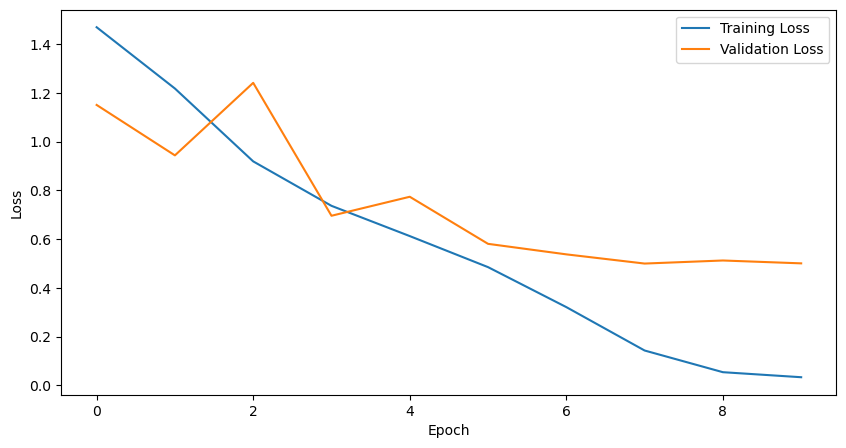

In [19]:
optim2 = torch.optim.Adam(model2.parameters(), lr=0.005, weight_decay=1e-5)
scheduler2 = torch.optim.lr_scheduler.OneCycleLR(optim2, max_lr=0.005, total_steps=10)
loss_fn = nn.CrossEntropyLoss()
train_model(model2, optim2, loss_fn, train_dl, valid_dl, scheduler=scheduler2, epochs=10, valid_every=1)

Since the model incorporates information from each resblock input into its output, you can make the model deeper and wider while improving learning and not losing too much information along the critical path. 

The resnet with less parameters 6M vs 6.5M still performs better on the validation set than the regular convnet. The resnet gets upto 85.5% accuracy vs 76.1% for the convnet. 

When we give the resnet as much width as out convnet, the number fo parameters rises to 19.5M. The improvement in validation accuracy, however, was marginal (85.9% vs 85.5%). 
